In [10]:
import matplotlib.pyplot as plt
import numpy as np

In [11]:
class WindyGridWorld:
    def __init__(self, width=10, height=7):
        self.width = width
        self.height = height
        self.start = (0, 5)
        self.state_pos = self.start
        self.goal = (7, 3)
        self.windy_cells = [(i, j) for i in range(3, 7) for j in range(2, 6)]  # 上界之风的格子
        self.wind_strength = 1

    def reset(self):
        self.state_pos = self.start
        return self.start

    def step(self, state, action):
        x, y = state
        if action == 0:  # 上
            y = max(0, y - 1)
        elif action == 1:  # 下
            y = min(self.height - 1, y + 1)
        elif action == 2:  # 左
            x = max(0, x - 1)
        elif action == 3:  # 右
            x = min(self.width - 1, x + 1)

        # 上界之风
        if (x, y) in self.windy_cells:
            y -= self.wind_strength # 上移1格

        # 确保y不越界(上界之风)
        next_state = (x, max(0, min(self.height - 1, y)))
        reward = -1 if next_state != self.goal else 0
        done = next_state == self.goal
        # Note: linear state-index = self.y * self.ncol + self.x
        self.state_pos = next_state # update state
        return next_state, reward, done
    

In [12]:
class Sarsa_Expected:
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.ncol = ncol
        self.nrow = nrow
        self.Q_table = np.zeros([nrow * ncol, n_action])  # 初始化Q(s,a)表格
        self.n_action = n_action  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        # action_pi = np.array([[0.25, 0.25, 0.25, 0.25]])  # 上、下、左、右
        # self.pi = np.repeat(action_pi, nrow * ncol, axis=0)
        self.pi = np.ones([nrow * ncol, n_action]) / n_action # 初始化为均匀随机策略
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数
    
    # epsilon-greedy strategy
    def action_selection(self, state):
        # Note transform state tuple to linear state-index:
        # state_idx = state[1] * self.ncol + state[0] 
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            state_idx = state[1] * self.ncol + state[0]  # 将状态转换为线性索引
            action = np.argmax(self.Q_table[state_idx])  # 贪婪选择动作
        return action
    
    def Q_update(self, state, action, reward, nxt_state):
        # calculate expected Q from sum{Pr_\pi(a|s) * Q(s',a')}
        Q_expected = 0
        state_idx = state[1] * self.ncol + state[0]  # 将当前状态转换为线性索引
        nxt_state_idx = nxt_state[1] * self.ncol + nxt_state[0]  # 将下一个状态转换为线性索引

        ## 注意，Expected-Sarsa的条件期望需要仔细调整

        for nxt_a in range(self.n_action):
            Q_expected += self.pi[nxt_state_idx, nxt_a]*self.Q_table[nxt_state_idx, nxt_a]
        # Q_expected = np.max(self.Q_table[nxt_state_idx])  # 直接使用最大Q值作为期望Q值
        # update Q(s,a)
        self.Q_table[state_idx, action] += self.alpha * (reward + self.gamma * Q_expected - self.Q_table[state_idx, action])
    
    def Sarsa_expected(self, env, episodes, max_steps=500):
        reward_list = np.zeros(episodes)  # 用于存储每个episode的总奖励
        step_ep_list = np.zeros(episodes)  # 用于存储每个episode的步数
        for ep in range(episodes):
            state = env.reset()
            done = False

            while (step_ep_list[ep] < max_steps) and (not done):
                action = self.action_selection(state)
                nxt_state, reward, done = env.step(state, action)
                # nxt_action = self.action_selection(nxt_state)
                reward_list[ep] += reward
                step_ep_list[ep] += 1
                self.Q_update(state, action, reward, nxt_state)
                state = nxt_state
                
            # Print average reward for each 10 episodes
            if (ep + 1) % 10 == 0:
                print(f'Episode {ep + 1}/{episodes}, Average Reward: {np.mean(reward_list[max(0, ep - 9):ep + 1])}')
        
        # policy extraction
        policy = np.argmax(self.Q_table, axis=1)
        
        return reward_list, step_ep_list, self.Q_table, policy
                

Episode 10/500, Average Reward: -127.9
Episode 20/500, Average Reward: -91.4
Episode 30/500, Average Reward: -76.2
Episode 40/500, Average Reward: -50.3
Episode 50/500, Average Reward: -75.9
Episode 60/500, Average Reward: -42.4
Episode 70/500, Average Reward: -39.3
Episode 80/500, Average Reward: -49.4
Episode 90/500, Average Reward: -43.3
Episode 100/500, Average Reward: -27.9
Episode 110/500, Average Reward: -36.4
Episode 120/500, Average Reward: -25.8
Episode 130/500, Average Reward: -36.8
Episode 140/500, Average Reward: -30.5
Episode 150/500, Average Reward: -36.2
Episode 160/500, Average Reward: -26.3
Episode 170/500, Average Reward: -33.6
Episode 180/500, Average Reward: -22.5
Episode 190/500, Average Reward: -35.1
Episode 200/500, Average Reward: -27.7
Episode 210/500, Average Reward: -30.9
Episode 220/500, Average Reward: -20.4
Episode 230/500, Average Reward: -26.3
Episode 240/500, Average Reward: -23.7
Episode 250/500, Average Reward: -17.4
Episode 260/500, Average Reward: 

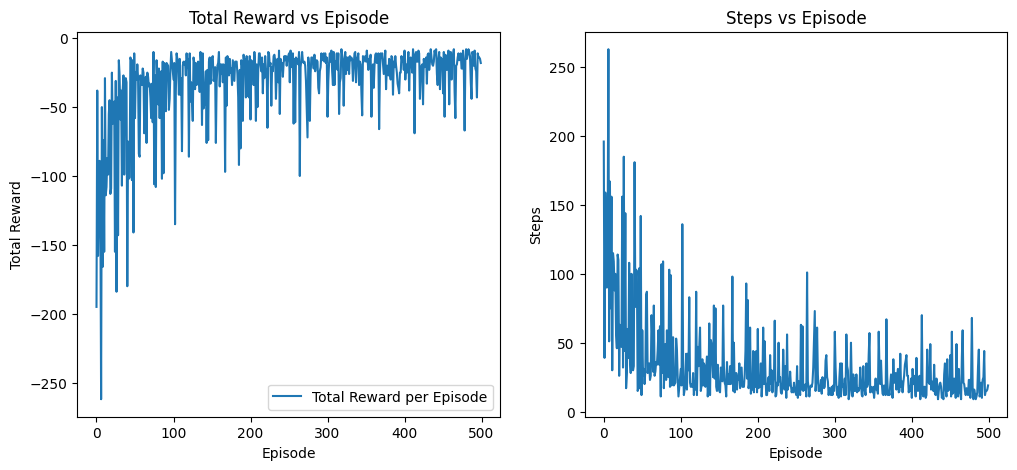

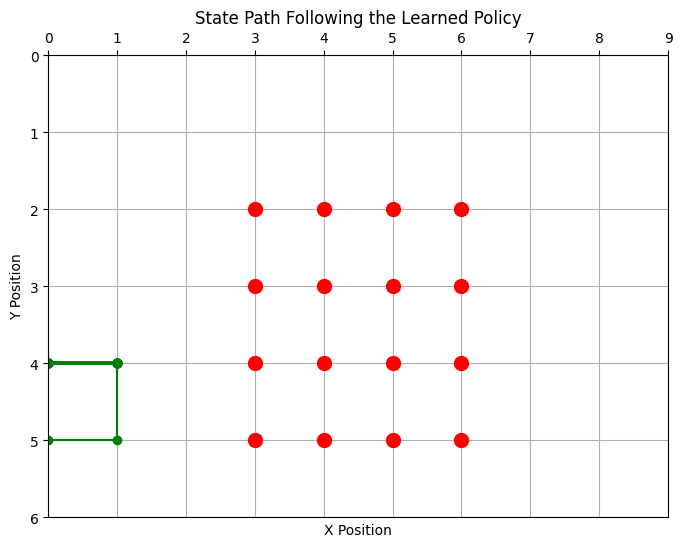

In [13]:
# Main Program
# initialize environment and parameters
env = WindyGridWorld()
np.random.seed(191)  # 设置随机种子以便复现
ncol = env.width
nrow = env.height
epsilon = 0.25
alpha = 0.1 # learning rate(approximation of 1/N)
gamma = 0.9  # discount factor
agent = Sarsa_Expected(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500

# Train the agent
reward_list, step_ep_list, Q_table, policy = agent.Sarsa_expected(env, num_episodes)

# Simulate the learned policy
state_policy_list = []
action_policy_list = []
done = False
sim_step = 0
reward_total = 0
env.reset()  # 重置环境
state_policy_list.append(env.state_pos)  # 记录初始状态
while (not done) and sim_step < 100:
    state_idx = env.state_pos[1] * ncol + env.state_pos[0]  # 将状态转换为线性索引
    action = policy[state_idx]  # 从初始状态获取动作
    nxt_state, reward, done = env.step(env.state_pos, action)
    reward_total += reward
    # record the state and action
    state_policy_list.append(env.state_pos)
    action_policy_list.append(action)
    # update the state_idx
    state_idx = nxt_state[1] * ncol + nxt_state[0]  # 更新状态索引
    # check termination condition
    if env.state_pos == env.goal:
        done = True
    sim_step += 1

# Plot the learning results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(reward_list, label='Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episode')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(step_ep_list, label='Steps per Episode')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Steps vs Episode')
plt.show()

# Plot the simulation
plt.figure(figsize=(8, 6))
plt.plot(*zip(*state_policy_list), marker='o', label='State Path', color='green')
plt.grid(True)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('State Path Following the Learned Policy')
plt.xlim(0, ncol-1)
plt.ylim(0, nrow-1)
plt.gca().invert_yaxis()  # Invert y-axis to match grid orientation
plt.gca().xaxis.set_ticks_position('top')

# Plot the windy cells
for cell in env.windy_cells:
    plt.plot(cell[0], cell[1], 'ro', markersize=10, label='Windy Cell' if cell == env.windy_cells[0] else "")


In [32]:
env.state_pos

(7, 3)

### Stochastic Wind (RL exercise by Sutton, C6-5) 
Re-solve the windy gridworld task with King’s moves, assuming that the effect of the wind, if there is any, is stochastic, sometimes varying by 1 from the mean values given for each column. That is, a third of the time you move exactly according to these values, as in the previous exercise, but also a third of the time you move one cell above that, and another third of the time you move one cell below that. For example, if you are one cell to the right of the goal and you move left, then one-third of the time you move one cell above the goal, one-third of the time you move two cells above the goal, and one-third of the time you move to the goal.

### TD(0) Sarsa Algorithm (explicit Policy)

In [33]:
## Stochastic wind disturbance (wind direction: up or down)
class WindyGridWorld_Stochastic:
    def __init__(self, width=10, height=7):
        self.width = width
        self.height = height
        self.start = (0, 5)
        self.state_pos = self.start
        self.goal = (7, 3)
        self.windy_cells = [(i, j) for i in range(3, 7) for j in range(2, 6)]  # 上界之风的格子
        self.wind_strength = 1
    
    def reset(self):
        self.state_pos = self.start
        return self.start

    def step(self, state, action):
        x, y = state
        if action == 0:  # 上
            y = max(0, y - 1)
        elif action == 1:  # 下
            y = min(self.height - 1, y + 1)
        elif action == 2:  # 左
            x = max(0, x - 1)
        elif action == 3:  # 右
            x = min(self.width - 1, x + 1)

        # # 随机风向扰动：有50%的概率上移或下移
        # if (x, y) in self.windy_cells:
        #     if np.random.rand() < 0.5:
        #         y -= self.wind_strength  # 上移1格
        #     else:
        #         y += self.wind_strength  # 下移1格
        
        # 固定风向扰动：上移1格
        if (x, y) in self.windy_cells:
            y -= self.wind_strength  # 上移1格

        # 确保y不越界(上界之风)
        next_state = (x, max(0, min(self.height - 1, y)))
        reward = -1 if next_state != self.goal else 0
        done = next_state == self.goal
        self.state_pos = next_state  # update state
        return next_state, reward, done

In [34]:
class Sarsa_Basic:
    '''
    Basic Sarsa algorithm implementation.
    TD(0) with epsilon-greedy policy.
    '''
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.ncol = ncol
        self.nrow = nrow
        self.Q_table = np.zeros([nrow * ncol, n_action])  # 初始化Q(s,a)表格
        self.n_action = n_action
        self.alpha = alpha
        self.gamma = gamma
        self.pi = np.ones([nrow * ncol, n_action]) / n_action
        self.epsilon = epsilon
    
    # epsilon-greedy strategy
    def action_selection(self, state):
        # Note transform state tuple to linear state-index:
        # state_idx = state[1] * self.ncol + state[0] 
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            state_idx = state[1] * self.ncol + state[0]  # 将状态转换为线性索引
            action = np.argmax(self.Q_table[state_idx])  # 贪婪选择动作
        return action
    
    def Q_update(self, state, action, reward, nxt_state, nxt_action):
        # 将状态转换为线性索引
        state_idx = state[1] * self.ncol + state[0]
        nxt_state_idx = nxt_state[1] * self.ncol + nxt_state[0]
        # update Q(s,a) in Sarsa
        self.Q_table[state_idx, action] += self.alpha * (reward + self.gamma * self.Q_table[nxt_state_idx, nxt_action] - self.Q_table[state_idx, action])

    def sarsa_main(self, env, episodes, max_steps=500):
        reward_list = np.zeros(episodes)
        step_ep_list = np.zeros(episodes)
        for ep in range(episodes):
            state = env.reset()
            action = self.action_selection(state)
            done = False
            while step_ep_list[ep] < max_steps and not done:
                nxt_state, reward, done = env.step(state, action)
                nxt_action = self.action_selection(nxt_state)
                # update Q(s,a)
                self.Q_update(state, action, reward, nxt_state, nxt_action)
                # log reward and step count
                reward_list[ep] += reward
                step_ep_list[ep] += 1
                # check termination condition
                if env.state_pos == env.goal:
                    done = True
                # update state and action
                state = nxt_state
                action = nxt_action
            
            # Print average reward for each 10 episodes
            if (ep + 1) % 10 == 0:
                print(f'Episode {ep + 1}/{episodes}, Average Reward: {np.mean(reward_list[max(0, ep - 9):ep + 1])}')

            # policy extraction
            policy = np.argmax(self.Q_table, axis=1)
            
        return reward_list, step_ep_list, self.Q_table, policy

Episode 10/500, Average Reward: -127.1
Episode 20/500, Average Reward: -93.1
Episode 30/500, Average Reward: -73.7
Episode 40/500, Average Reward: -49.8
Episode 50/500, Average Reward: -52.3
Episode 60/500, Average Reward: -41.4
Episode 70/500, Average Reward: -41.4
Episode 80/500, Average Reward: -47.1
Episode 90/500, Average Reward: -39.2
Episode 100/500, Average Reward: -29.7
Episode 110/500, Average Reward: -35.9
Episode 120/500, Average Reward: -31.4
Episode 130/500, Average Reward: -26.8
Episode 140/500, Average Reward: -27.7
Episode 150/500, Average Reward: -30.8
Episode 160/500, Average Reward: -26.0
Episode 170/500, Average Reward: -30.0
Episode 180/500, Average Reward: -23.0
Episode 190/500, Average Reward: -27.6
Episode 200/500, Average Reward: -21.3
Episode 210/500, Average Reward: -27.1
Episode 220/500, Average Reward: -18.2
Episode 230/500, Average Reward: -17.5
Episode 240/500, Average Reward: -19.4
Episode 250/500, Average Reward: -20.4
Episode 260/500, Average Reward: 

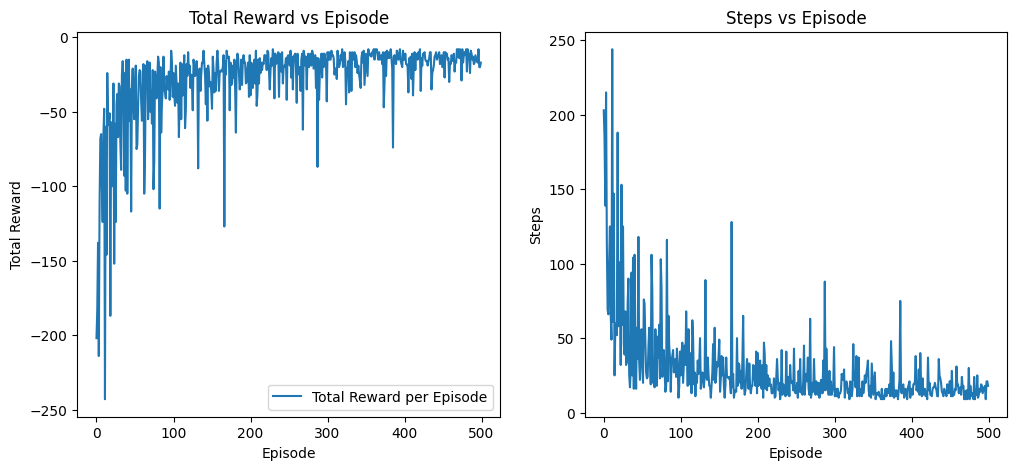

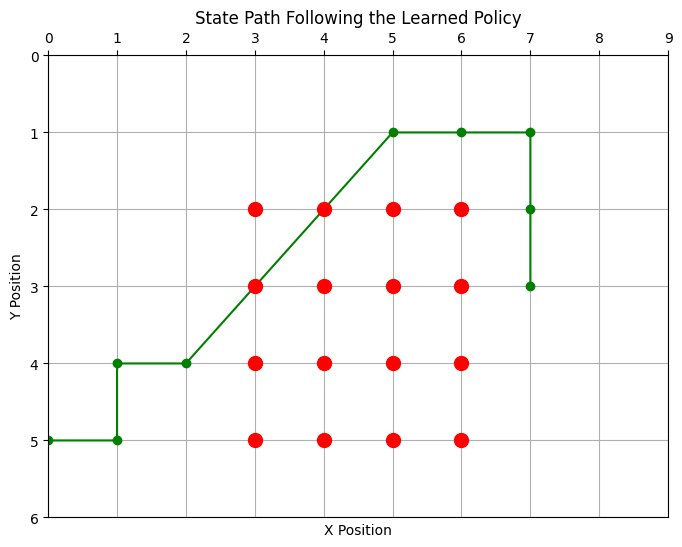

In [35]:
## Main Program for Basic Sarsa
# initialize environment and parameters
env = WindyGridWorld_Stochastic()
np.random.seed(191)  # 设置随机种子以便复现
ncol = env.width
nrow = env.height
epsilon = 0.25
alpha = 0.1 # learning rate(approximation of 1/N)
gamma = 0.9  # discount factor
agent = Sarsa_Basic(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500

# Train the agent
reward_list, step_ep_list, Q_table, policy = agent.sarsa_main(env, num_episodes)
# Simulate the learned policy
state_policy_list = []
action_policy_list = []
done = False
sim_step = 0
reward_total = 0
env.reset()  # 重置环境
state_policy_list.append(env.state_pos)  # 记录初始状态
while (not done) and sim_step < 100:
    state_idx = env.state_pos[1] * ncol + env.state_pos[0]  # 将状态转换为线性索引
    action = policy[state_idx]  # 从初始状态获取动作
    nxt_state, reward, done = env.step(env.state_pos, action)
    reward_total += reward
    # record the state and action
    state_policy_list.append(env.state_pos)
    action_policy_list.append(action)
    # update the state_idx
    state_idx = nxt_state[1] * ncol + nxt_state[0]  # 更新状态索引
    # check termination condition
    if env.state_pos == env.goal:
        done = True
    sim_step += 1

# Plot the learning results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(reward_list, label='Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episode')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(step_ep_list, label='Steps per Episode')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Steps vs Episode')
plt.show()

# Plot the simulation
plt.figure(figsize=(8, 6))
plt.plot(*zip(*state_policy_list), marker='o', label='State Path', color='green')
plt.grid(True)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('State Path Following the Learned Policy')
plt.xlim(0, ncol-1)
plt.ylim(0, nrow-1)
plt.gca().invert_yaxis()  # Invert y-axis to match grid orientation
plt.gca().xaxis.set_ticks_position('top')

# Plot the windy cells
for cell in env.windy_cells:
    plt.plot(cell[0], cell[1], 'ro', markersize=10, label='Windy Cell' if cell == env.windy_cells[0] else "")

